### Importing the required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Loading Cleaned Dataset

In [3]:
df = pd.read_csv('Algerian forest fire_cleaned.csv')

In [4]:
df

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239,26,9,2012,30,65,14,0.0,85.4,16.0,44.5,4.5,16.9,6.5,fire,1
240,27,9,2012,28,87,15,4.4,41.1,6.5,8.0,0.1,6.2,0.0,not fire,1
241,28,9,2012,27,87,29,0.5,45.9,3.5,7.9,0.4,3.4,0.2,not fire,1
242,29,9,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,1


In [5]:
df['Classes'] = df['Classes'].replace({'not fire':0, 'fire':1})

#### Feature and target columns

In [6]:
x = df.drop(columns=['Classes'])
y = df.Classes

In [7]:
x.head()

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Region
0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,0
1,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,0
2,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,0
3,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,0
4,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,0


In [8]:
y

0      0
1      0
2      0
3      0
4      0
      ..
239    1
240    0
241    0
242    0
243    0
Name: Classes, Length: 244, dtype: int64

### Check for multicolinearity using VIF and correlation matrix

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

def vif_score(df):
    #scaler = StandardScaler()
    #df_arr = scaler.fit_transform(df)
    df_vif = pd.DataFrame()
    df_vif['Feature'] = df.columns
    df_vif['VIF'] = [variance_inflation_factor(df.values,i) for i in range(len(df.columns))]
    #df_vif['VIF'] = [variance_inflation_factor(df_arr,i) for i in range(df_arr.shape[1])]
    return df_vif

In [10]:
vif_score(x)

,Feature,VIF
0,day,1.488840
1,month,1.093791
2,year,518.073897
3,Temperature,2.426880
4,RH,2.884722
5,Ws,1.302306
6,Rain,1.550498
7,FFMC,4.129014
8,DMC,83.616434
9,DC,25.558143


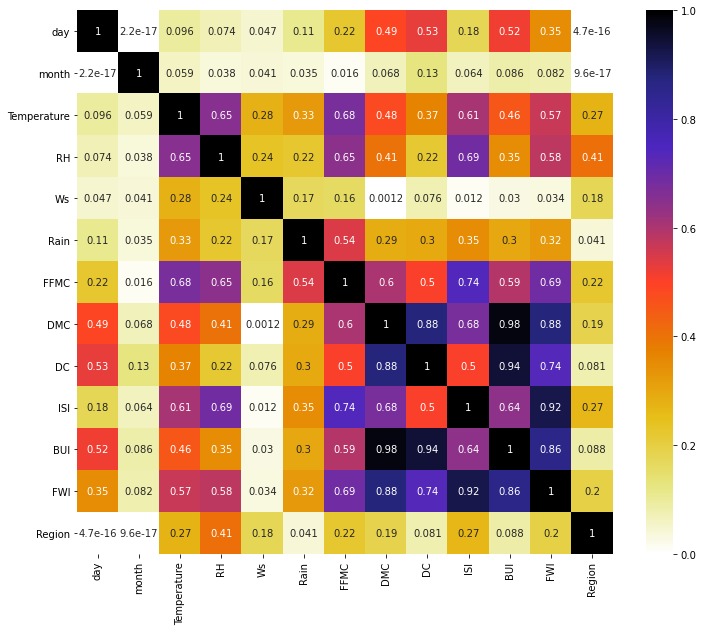

In [11]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = x.drop(columns=['year']).corr().abs()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [12]:
# Absolute values of Correlation matrix
corr_df = x.corr().abs()
# output array of True(dtype=bool) with the same shape as `corr_df`
bool_arr = np.ones_like(corr_df, dtype=bool)
# Upper triangle of an array
mask = np.triu(bool_arr)
# Mask method
tri_df = corr_df.mask(mask)
# find columns that exceed threshold
to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.9)]
print(to_drop)

['DMC', 'DC', 'ISI']


#### Custom function to obtain the highly correlated feature columns

In [13]:
def get_correlated_cols(data, threshold):
    corr_col1 = set()      # creating a set of all unique columns
    corr_col2 = set()
    corr_df = data.corr().abs()          # correlation matrix containing absolute values
    for i in range(len(corr_df.columns)):
        for j in range(i):
            if corr_df.iloc[i,j] > threshold:
                # we can drop either one of the correlated columns, we can use either corr_df.columns[i] or corr_df.columns[j]
                col_name1 = corr_df.columns[j]     # getting the column name
                col_name2 = corr_df.columns[i]
                corr_col1.add(col_name1)
                corr_col2.add(col_name2)
    return corr_col1, corr_col2

We have considered correlation threshold as 0.9

In [14]:
corr_cols = get_correlated_cols(x, 0.9)
corr_cols

({'DC', 'DMC', 'ISI'}, {'BUI', 'FWI'})

#### Dropping the highly correlated columns

In [15]:
#x.drop(corr_cols[0], axis=1, inplace=True)
x.drop(corr_cols[1], axis=1, inplace=True)
x.shape

(244, 12)

In [16]:
x = x.drop(['year'], axis=1)
x.shape

(244, 11)

<AxesSubplot:>

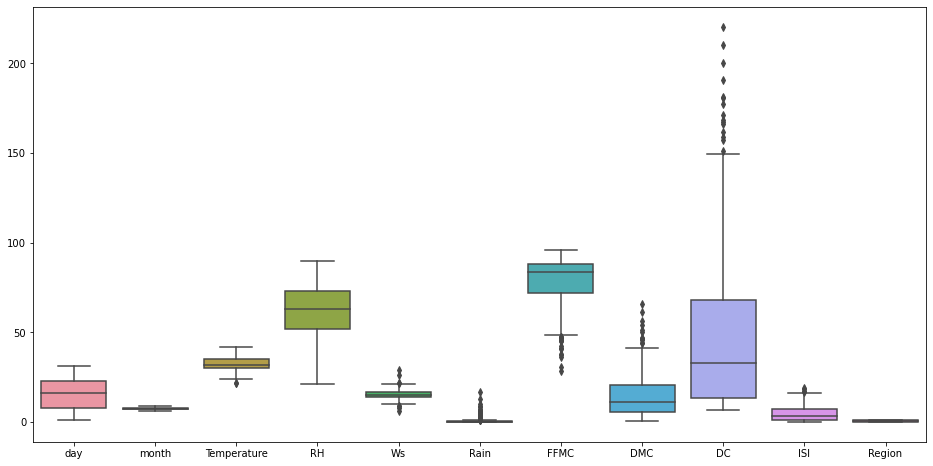

In [17]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=x)

### Outlier Detection

In [19]:
def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers

for col in x.columns:
    sample_outliers = detect_outliers_iqr(x[col])
    print(f"Outliers from IQR method for {col} are {sample_outliers}")

Outliers from IQR method for day are []
Outliers from IQR method for month are []
Outliers from IQR method for Temperature are [22, 22]
Outliers from IQR method for RH are []
Outliers from IQR method for Ws are [6, 8, 9, 9, 22, 22, 26, 29]
Outliers from IQR method for Rain are [1.3, 1.3, 1.4, 1.4, 1.7, 1.8, 1.8, 1.8, 1.9, 2.0, 2.0, 2.0, 2.2, 2.5, 2.9, 2.9, 3.1, 3.1, 3.8, 3.8, 4.0, 4.1, 4.4, 4.5, 4.6, 4.7, 5.8, 6.0, 6.5, 7.2, 8.3, 8.7, 10.1, 13.1, 16.8]
Outliers from IQR method for FFMC are [28.6, 30.5, 36.1, 37.3, 37.9, 40.9, 41.1, 42.6, 44.9, 45.0, 45.9, 46.0, 47.1, 47.4, 47.4, 47.4]
Outliers from IQR method for DMC are [43.9, 44.2, 45.6, 46.1, 46.6, 47.0, 50.2, 51.3, 54.2, 56.3, 61.3, 65.9]
Outliers from IQR method for DC are [151.3, 157.5, 159.1, 161.5, 166.0, 167.2, 168.2, 171.3, 177.3, 180.4, 181.3, 190.6, 200.2, 210.4, 220.4]
Outliers from IQR method for ISI are [16.6, 17.2, 18.5, 19.0]
Outliers from IQR method for Region are []


### Quantile based flooring and capping

In [20]:
for col in x:
    q_1 = x[col].quantile(0.25)
    q_3 = x[col].quantile(0.75)
    iq_range = q_3 - q_1
    lwr_fence = q_1 - (1.5*iq_range)
    upr_fence = q_3 + (1.5*iq_range)
    
    print(f"Lower and upper fence for {col} is {lwr_fence} and {upr_fence} respectively.")
    #print('\n')
    
    x[col] = np.where(x[col] < lwr_fence, lwr_fence, x[col])
    x[col] = np.where(x[col] > upr_fence, upr_fence, x[col])

print("New Shape after flooring and capping outliers: ", x.shape)

Lower and upper fence for day is -14.5 and 45.5 respectively.
Lower and upper fence for month is 5.5 and 9.5 respectively.
Lower and upper fence for Temperature is 22.5 and 42.5 respectively.
Lower and upper fence for RH is 20.125 and 105.125 respectively.
Lower and upper fence for Ws is 9.5 and 21.5 respectively.
Lower and upper fence for Rain is -0.75 and 1.25 respectively.
Lower and upper fence for FFMC is 47.73750000000001 and 112.63749999999999 respectively.
Lower and upper fence for DMC is -16.624999999999996 and 43.175 respectively.
Lower and upper fence for DC is -69.03750000000002 and 150.46250000000003 respectively.
Lower and upper fence for ISI is -7.450000000000001 and 16.150000000000002 respectively.
Lower and upper fence for Region is -1.5 and 2.5 respectively.
New Shape after flooring and capping outliers:  (244, 11)


<AxesSubplot:>

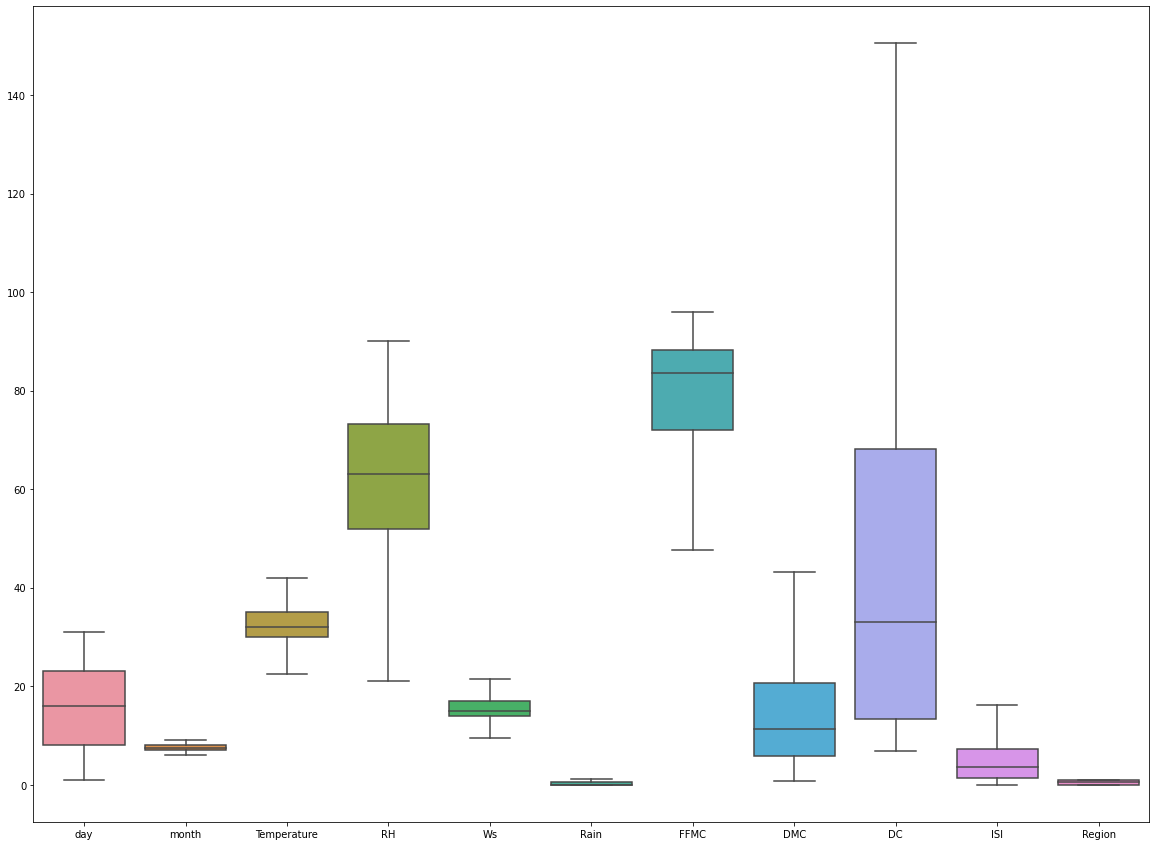

In [21]:
fig, ax = plt.subplots(figsize = (20, 15))
sns.boxplot(data = x, ax = ax)

In [18]:
# dropping columns which may not help in regression model
#x.drop(columns=['day','month'], inplace=True)   # keeping cols Classes and Region doesn't improve our R2 score
x.drop(columns=['day','month','Region'], inplace=True)
x

,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI
0,29,57,18,0.0,65.7,3.4,7.6,1.3
1,29,61,13,1.3,64.4,4.1,7.6,1.0
2,26,82,22,13.1,47.1,2.5,7.1,0.3
3,25,89,13,2.5,28.6,1.3,6.9,0.0
4,27,77,16,0.0,64.8,3.0,14.2,1.2
...,...,...,...,...,...,...,...,...
239,30,65,14,0.0,85.4,16.0,44.5,4.5
240,28,87,15,4.4,41.1,6.5,8.0,0.1
241,27,87,29,0.5,45.9,3.5,7.9,0.4
242,24,54,18,0.1,79.7,4.3,15.2,1.7


### Train test split

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=12)

In [20]:
x_train.shape, x_test.shape

((183, 8), (61, 8))

In [21]:
y_train.shape, y_test.shape

((183,), (61,))

In [22]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
x_train_scaled = std_scaler.fit_transform(x_train)
# we get ndarray after fit_transform method of scaler class, we convert this array to dataframe
df_xtrain_scaled= pd.DataFrame(x_train_scaled,columns=x_train.columns)
x_test_scaled = std_scaler.transform(x_test)

Text(0.5, 1.0, 'x_train after scaling')

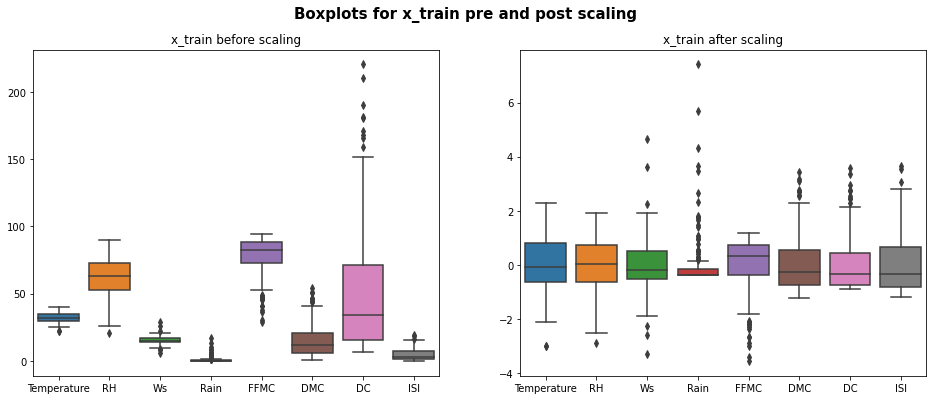

In [23]:
plt.figure(figsize=(16,6))
plt.suptitle("Boxplots for x_train pre and post scaling", fontsize = 15, fontweight='bold')

plt.subplot(1,2,1)
sns.boxplot(data=x_train)
plt.title('x_train before scaling')
plt.subplot(1,2,2)
sns.boxplot(data=df_xtrain_scaled)
plt.title('x_train after scaling')

### Model Training

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, \
                            precision_score, recall_score,f1_score, roc_auc_score, roc_curve, log_loss, matthews_corrcoef

# AUC ROC indicates how well the probabilities from the positive classes are separated from the negative classes

In [25]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Gaussian Naive Bayes': GaussianNB(),
    'K Neighbours Classifier': KNeighborsClassifier(),
    'Support Vector Classifier': SVC(),
    'Decision Tree Classifier': DecisionTreeClassifier(),
    'Random Forest Classifier': RandomForestClassifier(),
    'XG Boost Classifier': XGBClassifier()
}

In [26]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(x_train_scaled, y_train)
    
    # making predictions
    y_train_pred = model.predict(x_train_scaled)
    y_test_pred = model.predict(x_test_scaled)
    
    # training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    model_train_precision = precision_score(y_train, y_train_pred)
    model_train_recall = recall_score(y_train, y_train_pred)
    model_train_roc_auc = roc_auc_score(y_train, y_train_pred) 
    model_train_log_loss = log_loss(y_train, y_train_pred)
    model_train_mcc = matthews_corrcoef(y_train, y_train_pred)
    
    # test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_roc_auc = roc_auc_score(y_test, y_test_pred)
    model_test_log_loss = log_loss(y_test, y_test_pred)
    model_test_mcc = matthews_corrcoef(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    
    print("Model performance for training set")
    
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- F1 Score: {:.4f}".format(model_train_f1))
    print("- ROC AUC Score: {:.4f}".format(model_train_roc_auc))
    print("- Log Loss: {:.4f}".format(model_train_log_loss))
    print("- Matthews Correlation Coefficient: {:.4f}".format(model_train_mcc))
    
    print("----------------------------------------------------")
    
    print("Model performance for test set")
    
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- F1 Score: {:.4f}".format(model_test_f1))
    print("- ROC AUC Score: {:.4f}".format(model_test_roc_auc))
    print("- Log Loss: {:.4f}".format(model_test_log_loss))
    print("- Matthews Correlation Coefficient: {:.4f}".format(model_test_mcc))
    
    print("="*35)
    print('\n')

Logistic Regression
Model performance for training set
- Accuracy: 0.9727
- Precision: 0.9712
- Recall: 0.9806
- F1 Score: 0.9727
- ROC AUC Score: 0.9715
- Log Loss: 0.9437
- Matthews Correlation Coefficient: 0.9445
----------------------------------------------------
Model performance for test set
- Accuracy: 0.9836
- Precision: 1.0000
- Recall: 0.9714
- F1 Score: 0.9836
- ROC AUC Score: 0.9857
- Log Loss: 0.5662
- Matthews Correlation Coefficient: 0.9672


Gaussian Naive Bayes
Model performance for training set
- Accuracy: 0.9563
- Precision: 0.9524
- Recall: 0.9709
- F1 Score: 0.9562
- ROC AUC Score: 0.9542
- Log Loss: 1.5099
- Matthews Correlation Coefficient: 0.9111
----------------------------------------------------
Model performance for test set
- Accuracy: 0.9508
- Precision: 0.9706
- Recall: 0.9429
- F1 Score: 0.9509
- ROC AUC Score: 0.9522
- Log Loss: 1.6986
- Matthews Correlation Coefficient: 0.9004


K Neighbours Classifier
Model performance for training set
- Accuracy: 0.

***Logistic Regression, Decision Tree, Random Forest and XGBoost Classifiers are the best performing models having high performance scores.***

### Logistic Regression

In [24]:
logistic_regression = LogisticRegression(solver='saga',penalty='elasticnet', verbose=1, l1_ratio=0.5)
logistic_regression.fit(x_train_scaled, y_train)

max_iter reached after 1 seconds


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga', verbose=1)

In [25]:
logistic_regression_pred = logistic_regression.predict(x_test_scaled)

#### Confusion Matrix

<img src="metrics.png" width="500">

### F1 Score

F1 score considers both Precision and Recall for evaluating a model.vIt is defined as the harmonic mean of Precision and Recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is. 

The mathematical formula is:
        F1 score= $ \frac {2*(Precision*Recall)}{(Precision+Recall)} $


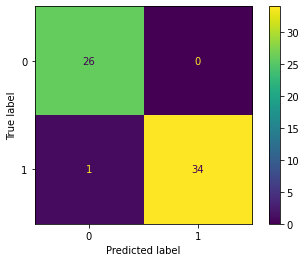

In [26]:
cm = confusion_matrix(y_test, logistic_regression_pred, labels=logistic_regression.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logistic_regression.classes_)
cm_display.plot()
plt.show()

Text(69.0, 0.5, 'Truth')

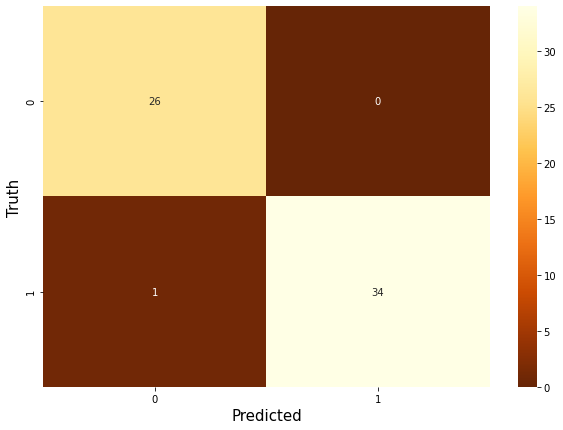

In [27]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap=plt.cm.YlOrBr_r)
plt.xlabel("Predicted", fontdict={"fontsize":15})
plt.ylabel("Truth", fontdict={"fontsize":15})

In [28]:
log_reg_accuracy = accuracy_score(y_test, logistic_regression_pred)
log_reg_f1 = f1_score(y_test, logistic_regression_pred)
log_reg_precision = precision_score(y_test, logistic_regression_pred)
log_reg_recall = recall_score(y_test, logistic_regression_pred)
log_reg_roc_auc_score = roc_auc_score(y_test, logistic_regression_pred)
log_reg_mcc = matthews_corrcoef(y_test, logistic_regression_pred)

print("Logistic Regression")
print("Accuracy Score value: {:.4f}".format(log_reg_accuracy))
print("F1 score: {:.4f}".format(log_reg_f1))
print("Precision: {:.4f}".format(log_reg_precision))
print("Recall: {:.4f}".format(log_reg_recall))
print("ROC AUC score: {:.4f}".format(log_reg_roc_auc_score))
print("Matthews Correlation Coefficient: {:.4f}".format(log_reg_mcc))

Logistic Regression
Accuracy Score value: 0.9836
F1 score: 0.9855
Precision: 1.0000
Recall: 0.9714
ROC AUC score: 0.9857
Matthews Correlation Coefficient: 0.9672


In [29]:
log_reg_roc_auc_score = roc_auc_score(y_test, logistic_regression_pred)
# roc_curve gives us false positive rate, true positive rate, threshold
fpr, tpr, thresholds = roc_curve(y_test, logistic_regression_pred)    

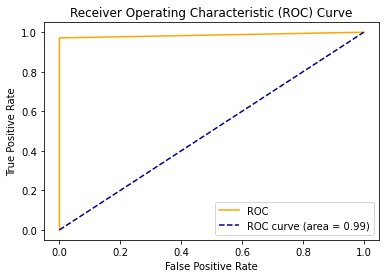

In [30]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % log_reg_roc_auc_score)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### Tuning Decision Tree Classifier

In [27]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [38]:
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth" : np.linspace(2, 100, 30, dtype=int),
    "min_samples_split": range(2,20,1),  # min no of samples required to split an internal node, to prevent tree from overfitting the training data
    "min_samples_leaf" : range(1,10,1),   # min number of samples required to be at a leaf node
    "max_features" : ["auto","sqrt","log2"]
}

dt_classifier = DecisionTreeClassifier()
rnd_cv = RandomizedSearchCV(estimator=dt_classifier, param_distributions=param_grid, cv=10, n_jobs=-1, verbose=1, random_state=25)
rnd_cv.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([  2,   5,   8,  12,  15,  18,  22,  25,  29,  32,  35,  39,  42,
        45,  49,  52,  56,  59,  62,  66,  69,  72,  76,  79,  83,  86,
        89,  93,  96, 100]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 20),
                                        'splitter': ['best', 'random']},
                   random_state=25, verbose=1)

In [39]:
rnd_cv.best_params_

{'splitter': 'best',
 'min_samples_split': 17,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 22,
 'criterion': 'gini'}

In [40]:
dt_best_model = rnd_cv.best_estimator_
dt_best_model.score(x_train_scaled, y_train)

0.9890710382513661

In [41]:
dt_best_model.score(x_test_scaled, y_test)

1.0

In [42]:
dt_pred = dt_best_model.predict(x_test_scaled)

In [43]:
dt_accuracy = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred)
dt_precision = precision_score(y_test,dt_pred)
dt_recall = recall_score(y_test, dt_pred)
dt_roc_auc_score = roc_auc_score(y_test, dt_pred)
dt_mcc = matthews_corrcoef(y_test, dt_pred)

print("Tuned Decision Tree")
print("Accuracy Score value: {:.4f}".format(dt_accuracy))
print("F1 score: {:.4f}".format(dt_f1))
print("Precision: {:.4f}".format(dt_precision))
print("Recall: {:.4f}".format(dt_recall))
print("ROC AUC score: {:.4f}".format(dt_roc_auc_score))
print("Matthews Correlation Coefficient: {:.4f}".format(dt_mcc))

Tuned Decision Tree
Accuracy Score value: 1.0000
F1 score: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC AUC score: 1.0000
Matthews Correlation Coefficient: 1.0000


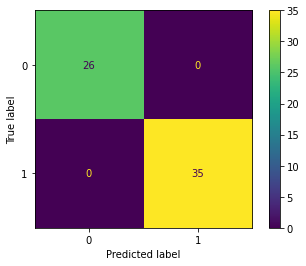

In [45]:
cm1= confusion_matrix(y_test, dt_pred, labels=dt_best_model.classes_)
cm1_display = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=dt_best_model.classes_)
cm1_display.plot()
plt.show()

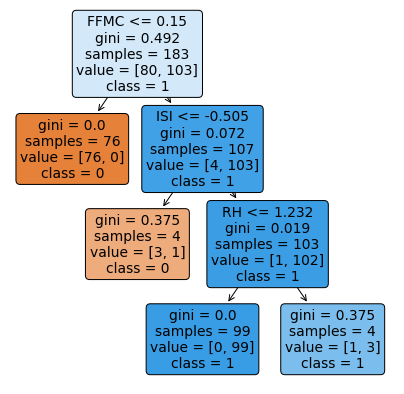

In [54]:
from sklearn import tree
plt.figure(figsize=(7,7))
tree.plot_tree(dt_best_model, filled=True, class_names=[str(i) for i in set(y)], feature_names=x_train.columns,\
              rounded=True)
plt.savefig("ForestFire_DecisionTree_graph")

DecisionTree in sklearn has a function called `cost_complexity_pruning_path`, which gives the `effective alphas` of subtrees during pruning and also the corresponding `impurities`. In other words, we can use these values of alpha to prune our decision tree.

It tells the cost complexity if we prune our DT or remove some of the branches. By default ccp_alpha value is zero i.e. it will go on growing and creating branches as long as it is able to divide the dataset. 

For any subtree T, we will define its complexity as |T~|, the number of terminal or leaf nodes in T. If we keep some value of ccp_alpha as threshold then in this case it will check the cost complexity of each and every branch, if cost complexity is greater than set threshold then it will prune or remove that branch.

In [56]:
# We pass training dataset to our ccp
path = dt_best_model.cost_complexity_pruning_path(x_train_scaled, y_train)
ccp_alpha = path.ccp_alphas
ccp_alpha

array([0.        , 0.00200364, 0.02839578, 0.03046141, 0.04549277,
       0.24338113])

****cost_complexity_pruning_path returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.  The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree with one node.****

In [57]:
dt_ccp_models = []
for alpha in ccp_alpha:
    dt_ccp = DecisionTreeClassifier(ccp_alpha=alpha)
    dt_ccp.fit(x_train_scaled,y_train)
    dt_ccp_models.append(dt_ccp)

In [58]:
# We have built 6 models.
dt_ccp_models

[DecisionTreeClassifier(),
 DecisionTreeClassifier(ccp_alpha=0.002003642987249551),
 DecisionTreeClassifier(ccp_alpha=0.028395784543325527),
 DecisionTreeClassifier(ccp_alpha=0.030461410941241482),
 DecisionTreeClassifier(ccp_alpha=0.04549277215827616),
 DecisionTreeClassifier(ccp_alpha=0.24338113184509863)]

***Greater values of ccp_alpha increase the number of nodes pruned.***

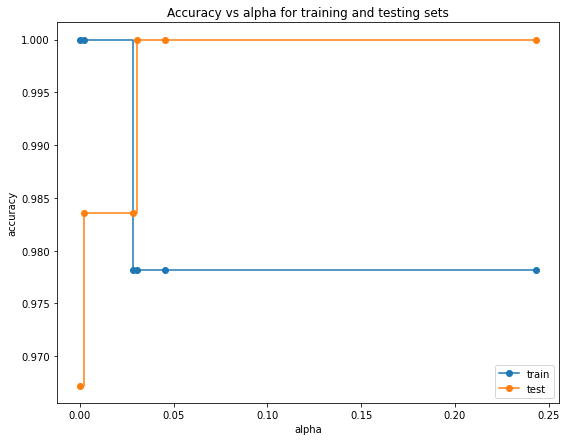

In [59]:
#I will select the value of ccp_alpha where train & test accuracies are close to each other.
train_scores = [i.score(x_train_scaled,y_train) for i in dt_ccp_models]
test_scores = [i.score(x_test_scaled,y_test) for i in dt_ccp_models]

fig, ax = plt.subplots(figsize=(9,7))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alpha, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alpha, test_scores, marker = 'o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

In [60]:
dt_model_ccp = DecisionTreeClassifier(ccp_alpha=0.03, random_state=0)
dt_model_ccp.fit(x_train_scaled,y_train)

DecisionTreeClassifier(ccp_alpha=0.03, random_state=0)

[Text(139.5, 285.39, 'ISI <= -0.531\ngini = 0.492\nsamples = 183\nvalue = [80, 103]\nclass = 1'),
 Text(69.75, 95.13, 'gini = 0.0\nsamples = 76\nvalue = [76, 0]\nclass = 0'),
 Text(209.25, 95.13, 'gini = 0.072\nsamples = 107\nvalue = [4, 103]\nclass = 1')]

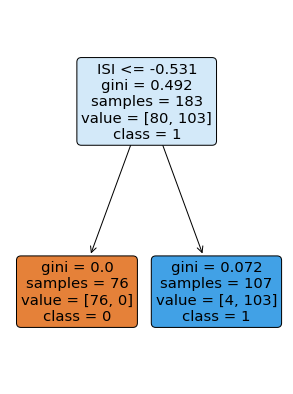

In [66]:
plt.figure(figsize=(5,7))
tree.plot_tree(dt_model_ccp, filled=True, class_names=[str(i) for i in set(y_train)], feature_names=x_train.columns,\
              rounded=True)

In [64]:
dt_model_ccp.score(x_train_scaled,y_train)

0.9781420765027322

In [65]:
dt_model_ccp.score(x_test_scaled,y_test)

0.9836065573770492

Now our training and testing accuracies are quite close to each other which we were expecting.

#### Tuning Random Forest Classifier

In [68]:
par_grid = {
    "n_estimators" : [50,70,90,100,120,140,160],
    "criterion": ["gini", "entropy"],
    "max_depth" : np.linspace(2, 50, 10, dtype=int),
    "min_samples_split": range(2,20,2),                  # min no of samples required to split an internal node
    "min_samples_leaf" : range(1,10,1),                  # min number of samples required to be at a leaf node
    "max_features" : ["auto","sqrt","log2"]
}

rf_classifier = RandomForestClassifier()
rf_randomcv = RandomizedSearchCV(estimator=rf_classifier, param_distributions=par_grid, cv=10, n_jobs=-1, verbose=2)
#rf_gridcv = GridSearchCV(estimator=rf_classifier, param_grid=par_grid, cv=10, n_jobs=-1, verbose=2)
rf_randomcv.fit(x_train_scaled, y_train)
#rf_gridcv.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 2,  7, 12, 18, 23, 28, 34, 39, 44, 50]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(1, 10),
                                        'min_samples_split': range(2, 20, 2),
                                        'n_estimators': [50, 70, 90, 100, 120,
                                                         140, 160]},
                   verbose=2)

In [69]:
rf_randomcv.best_params_

{'n_estimators': 100,
 'min_samples_split': 14,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 18,
 'criterion': 'entropy'}

In [70]:
# rf_best_model corresponds to randomized searchCV
rf_best_model = rf_randomcv.best_estimator_
rf_best_model.score(x_train_scaled, y_train)

0.9890710382513661

In [71]:
rf_best_model.score(x_test_scaled, y_test)

1.0

##### Grid SearchCV

In [46]:
rf_gridcv.best_params_

{'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 120}

In [47]:
# rf_model corresponds to grid searchCV
rf_model = rf_gridcv.best_estimator_
rf_model.score(x_train_scaled, y_train)

0.994535519125683

In [48]:
rf_model.score(x_test_scaled, y_test)

1.0

Considering rf_best_model for predictions

In [76]:
rf_pred = rf_best_model.predict(x_test_scaled)

In [77]:
rf_accuracy = accuracy_score(y_test,rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_precision = precision_score(y_test,rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_roc_auc_score = roc_auc_score(y_test, rf_pred)
rf_mcc = matthews_corrcoef(y_test,rf_pred)

print("Tuned Random Forest")
print("Accuracy Score value: {:.4f}".format(rf_accuracy))
print("F1 score: {:.4f}".format(rf_f1))
print("Precision: {:.4f}".format(rf_precision))
print("Recall: {:.4f}".format(rf_recall))
print("ROC AUC score: {:.4f}".format(rf_roc_auc_score))
print("Matthews Correlation Coefficient: {:.4f}".format(rf_mcc))

Tuned Random Forest
Accuracy Score value: 1.0000
F1 score: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC AUC score: 1.0000
Matthews Correlation Coefficient: 1.0000


In [78]:
rf_diff = pd.DataFrame({'Actual': y_test, 'pred': rf_pred})
rf_diff[rf_diff['Actual'] != rf_diff['pred']]

,Actual,pred


For all the data points in test set the actual and predicted values match. Hence, the score is 1.

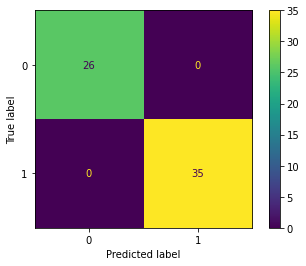

In [80]:
cm2= confusion_matrix(y_test, rf_pred, labels=dt_best_model.classes_)
cm2_display = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=dt_best_model.classes_)
cm1_display.plot()
plt.show()

#### Tuning XGBoost Classifier

In [100]:
grid_param = {
    "learning_rate" : np.linspace(0.05,1,100),
    "gamma" : np.linspace(0,0.5,10),
    "max_depth" : np.linspace(1, 30, 20, dtype=int),
    "min_child_weight" : [1, 3, 5, 7, 9, 11],
    "colsample_bytree" : [0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9],
    "tree_method" : ["auto","exact","approx","hist"],
    "grow_policy" : ['depthwise', 'lossguide']
}

xgb_classifier = XGBClassifier()

In [101]:
xgb_randcv = RandomizedSearchCV(estimator=xgb_classifier, param_distributions=grid_param, n_iter=5, scoring='roc_auc',\
                                cv=10, n_jobs=-1, verbose=2)
xgb_randcv.fit(x_train_scaled, y_train)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None...
       0.81767677, 0.82727273, 0.83686869, 0.84646465, 0.85606061,
       0.86565657, 0.87525253, 0.88484848, 0.89444444, 0.9040404 ,
    

In [102]:
xgb_randcv.best_params_

{'tree_method': 'approx',
 'min_child_weight': 1,
 'max_depth': 30,
 'learning_rate': 0.33787878787878783,
 'grow_policy': 'lossguide',
 'gamma': 0.38888888888888884,
 'colsample_bytree': 0.8}

In [103]:
xgb_best_model = xgb_randcv.best_estimator_
xgb_best_model.score(x_train_scaled, y_train)

0.9890710382513661

In [104]:
xgb_best_model.score(x_test_scaled, y_test)

1.0

In [105]:
xgb_pred = xgb_best_model.predict(x_test_scaled)

In [106]:
xgb_accuracy = accuracy_score(y_test,xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test,xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_roc_auc_score = roc_auc_score(y_test, xgb_pred)
xgb_mcc = matthews_corrcoef(y_test,xgb_pred)

print("Tuned XGBoost Classifier:")
print("Accuracy Score value: {:.4f}".format(xgb_accuracy))
print("F1 score: {:.4f}".format(xgb_f1))
print("Precision: {:.4f}".format(xgb_precision))
print("Recall: {:.4f}".format(xgb_recall))
print("ROC AUC score: {:.4f}".format(xgb_roc_auc_score))
print("Matthews Correlation Coefficient: {:.4f}".format(xgb_mcc))

Tuned XGBoost Classifier:
Accuracy Score value: 1.0000
F1 score: 1.0000
Precision: 1.0000
Recall: 1.0000
ROC AUC score: 1.0000
Matthews Correlation Coefficient: 1.0000


### KFold Techniques

**KFold:** Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default). Each fold is then used once as a validation while the k - 1 remaining folds form the training set.

**Stratified KFold:** Each fold will have equal amount of classes, so takes care of imabalanced class distributions. 

**Repeated Stratified KFold:** Repeats Stratified K-Fold n times with different randomization in each repetition.

In [107]:
from sklearn.model_selection import RepeatedStratifiedKFold
rs_kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=25)
rs_kfold

RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=25)

In [108]:
def get_score(model, xtrain, xtest, ytrain, ytest):
    model.fit(xtrain, ytrain)
    return model.score(xtest,ytest)

In [109]:
# no of folds: 244/10 = 24.4, so it will consider 24 or 25 datasets for testing and remaining for training
from statistics import mean
tdt_score= []
tdt_ccp_score= []
trf_score = []
xgb_score=[]

for train_id, test_id in rs_kfold.split(x,y):   #returns an iterator

    #print("TRAIN:", train_id, "TEST:", test_id)
    x_arr = x.to_numpy()
    y_arr = y.to_numpy()
    x_train_kfold, x_test_kfold, y_train_kfold, y_test_kfold = x_arr[train_id], x_arr[test_id], y_arr[train_id], y_arr[test_id]
    
    tdt_score.append(get_score(dt_best_model, x_train_kfold, x_test_kfold, y_train_kfold, y_test_kfold))
    tdt_ccp_score.append(get_score(dt_model_ccp, x_train_kfold, x_test_kfold, y_train_kfold, y_test_kfold))
    trf_score.append(get_score(rf_best_model, x_train_kfold, x_test_kfold, y_train_kfold, y_test_kfold))
    xgb_score.append(get_score(xgb_best_model, x_train_kfold, x_test_kfold, y_train_kfold, y_test_kfold))

print("Repeated Stratified KFold is applied to get the average scores for different tuned models:")
print(f"Tuned Decision Tree Classifier score: {mean(tdt_score)}")
print(f"ccp_alpha tuned Decision Tree Classifier score: {mean(tdt_ccp_score)}")
print(f"Tuned Random Forest Classifier score: {mean(trf_score)}")
print(f"Tuned XGBoost Classifier score: {mean(xgb_score)}")
#print('='*55)

Repeated Stratified KFold is applied to get the average scores for different tuned models:
Tuned Decision Tree Classifier score: 0.9689333333333333
ccp_alpha tuned Decision Tree Classifier score: 0.9705333333333334
Tuned Random Forest Classifier score: 0.9796
Tuned XGBoost Classifier score: 0.9853


In [110]:
from sklearn.model_selection import cross_val_score

def get_cross_val_Score(model, model_name):
    
    cv_model= cross_val_score(model, x, y, cv=rs_kfold, scoring='accuracy').mean()
    print('Cross Validation Score for Tuned {} is {:.4f}'.format(model_name, cv_model))

In [111]:
get_cross_val_Score(dt_best_model, "Decision Tree Classifier")

Cross Validation Score for Tuned Decision Tree Classifier is 0.9655


In [112]:
get_cross_val_Score(dt_model_ccp, "ccp_alpha tuned Decision Tree Classifier")

Cross Validation Score for Tuned ccp_alpha tuned Decision Tree Classifier is 0.9705


In [113]:
get_cross_val_Score(rf_best_model, "Random Forest Classifier")

Cross Validation Score for Tuned Random Forest Classifier is 0.9820


In [114]:
get_cross_val_Score(xgb_best_model, "XGBoost Classifier")

Cross Validation Score for Tuned XGBoost Classifier is 0.9853


### **Score Comparison**

| Models     | Accuracy score  |
| ----------- | ----------- |
|   Logistic Regression   | 98.36 % |
| Gaussian NB  | 95.08 % |
| K Neighbors Classifier  | 86.89 %|
| Support Vector Classifier  | 95.08 %|
| Decision Tree Classifier  | 96.55 % |
| ccp_alpha tuned Decision Tree Classifier  | 97.05 % |
| Random Forest Classifier  | 98.2 %|
| XGBoost Classifier  | 98.53 % |

In [132]:
import bz2,pickle
file = bz2.BZ2File('algerian_clf_model.pkl','wb')
pickle.dump(xgb_best_model,file)
file.close()